In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

In [2]:
def readCandlesToDataFrame(fileName: str) -> pd.DataFrame:
    df = pd.read_csv(fileName, delimiter=',', header=None, names=['Open', 'High', 'Low', 'Close', 'Volume', 'Date'])
    df.drop(columns=['Volume'], inplace=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d-%m-%Y %H:%M:%S')
    df.index = range(len(df))
    return df

def calculateLogReturns(df: pd.DataFrame) -> pd.DataFrame:
    df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Pct Change'] = df['Close'].pct_change()
    
    # there are implementations that use pct change instead of log returns
    # which doesnt really matter because for small x log(x) is approximately equal to x and well, pct change is just x
    # but log returns are more accurate for larger values so idk
    # certainly wont be using returns though, quite simply because garch is more consistent with log normailty plus additive (pun intended) 
    
    # just go thorugh this discussion: https://quant.stackexchange.com/questions/75974/garch-on-returns-or-on-log-returns
    
    df.dropna(inplace=True)
    return df


In [3]:
df = readCandlesToDataFrame('./data/NIFTY__1d.txt')
daily_data = calculateLogReturns(df)

In [4]:
print(daily_data)

          Open      High       Low     Close                 Date  \
1      8291.35   8332.25   8245.60   8326.55  12-01-2015 09:15:00   
2      8346.15   8356.65   8268.15   8303.80  13-01-2015 09:15:00   
3      8307.25   8326.30   8236.75   8287.75  14-01-2015 09:15:00   
4      8425.20   8526.90   8380.75   8461.15  15-01-2015 09:15:00   
5      8467.45   8570.80   8459.35   8550.30  19-01-2015 09:15:00   
...        ...       ...       ...       ...                  ...   
2418  24349.85  24372.45  24172.60  24238.50  31-10-2024 09:15:00   
2419  24315.75  24316.75  23816.15  23990.95  04-11-2024 09:15:00   
2420  23916.50  24229.05  23842.75  24198.15  05-11-2024 09:15:00   
2421  24308.75  24537.60  24204.05  24493.90  06-11-2024 09:15:00   
2422  24489.60  24503.35  24179.05  24194.60  07-11-2024 09:15:00   

      Log Returns  Pct Change  
1        0.005576    0.005592  
2       -0.002736   -0.002732  
3       -0.001935   -0.001933  
4        0.020707    0.020922  
5        0.

In [5]:
def optimization_func(p, data):
    l = len(data)
    omega, alpha, beta = p[0], p[1], p[2]
    v = np.zeros(l)
    u = data['Log Returns']**2
    # u = data['Pct Change']**2
    s = 0
    
    for i in range(1, l):
        if i == 1:
            v[i] = omega/((10**5)*(1-alpha-beta))
        else:
            v[i] = omega/(10**5) + alpha*(u[i-1]) + beta*v[i-1]
            s = s - np.log(v[i]) - (u[i]/v[i])
    
    if alpha+beta <= 1:
        s = (-1)*s
        return s
    else:
        return 0

def estimate_garch_params(daily_data):
    omega, alpha, beta = 0.1, 0.05, 0.9
    vals = optimize.minimize(
        optimization_func, 
        x0=[omega, alpha, beta], 
        args=(daily_data),
        bounds=((0.001, 1), (0.001, 1), (0.001, 1))
    )
    
    omega = vals.x[0]/(10**5)
    alpha = vals.x[1]
    beta = vals.x[2]
    
    return omega, alpha, beta

In [6]:
omega, alpha, beta = estimate_garch_params(daily_data)
print(f"GARCH Parameters:")
print(f"Omega: {omega}")
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

/var/folders/gg/x2_nvmcn27qghblxt3h930sm0000gq/T/ipykernel_31302/323874611.py:14: RuntimeWarning: invalid value encountered in log
  s = s - np.log(v[i]) - (u[i]/v[i])


GARCH Parameters:
Omega: 2.5289613843853127e-06
Alpha: 0.10260973796086093
Beta: 0.8736813504375192


## nice params.
so right off the bat, alpha+beta is around 0.97 (decently close to 1) which means that the "memory" is quite high in the sense that larger shocks laster longer etc etc - long memory clustering. makes sense

also more importantly we would've chosen to go with some SMA or rather EWMA model (aryan parekh's idea) had omega been negative (not too sure about this i havent revised theory in some time now) but yeah omega>0 means it is mean reverting so good - garch makes sense

In [7]:
def plot_volatility_comparison(daily_data):
    plt.figure(figsize=(15, 8))
    
    # date bs bhai send help i've done too much pd.to_datetime in the last 3 months
    daily_data['Date'] = pd.to_datetime(daily_data['Date'], format='%d-%m-%Y %H:%M:%S')
    
    # Calculate Rolling Volatility
    daily_data['RollingVolatility'] = np.sqrt((daily_data['Log Returns']**2).rolling(21).mean())
    
    # GARCH Volatility estimate using my bren
    _, alpha, beta = estimate_garch_params(daily_data)
    l = daily_data.shape[0]
    v = np.zeros(l)
    u = daily_data['Log Returns']**2
    omega = 0.1/(10**5)
    
    for i in range(1, l):
        if i == 1:
            v[i] = omega/((10**5)*(1-alpha-beta))
        else:
            v[i] = omega/(10**5) + alpha*(u[i-1]) + beta*v[i-1]
    
    daily_data['GARCHVolatility'] = np.sqrt(v)
    
    
    plt.plot(daily_data['Date'], daily_data['RollingVolatility'], 
             label='21-day Rolling Volatility', alpha=0.7)
    plt.plot(daily_data['Date'], daily_data['GARCHVolatility'], 
             label='GARCH(1,1) Volatility', alpha=0.7)
    
    plt.title('Volatility Estimates: Rolling-21 vs GARCH(1,1)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/gg/x2_nvmcn27qghblxt3h930sm0000gq/T/ipykernel_31302/323874611.py:14: RuntimeWarning: invalid value encountered in log
  s = s - np.log(v[i]) - (u[i]/v[i])


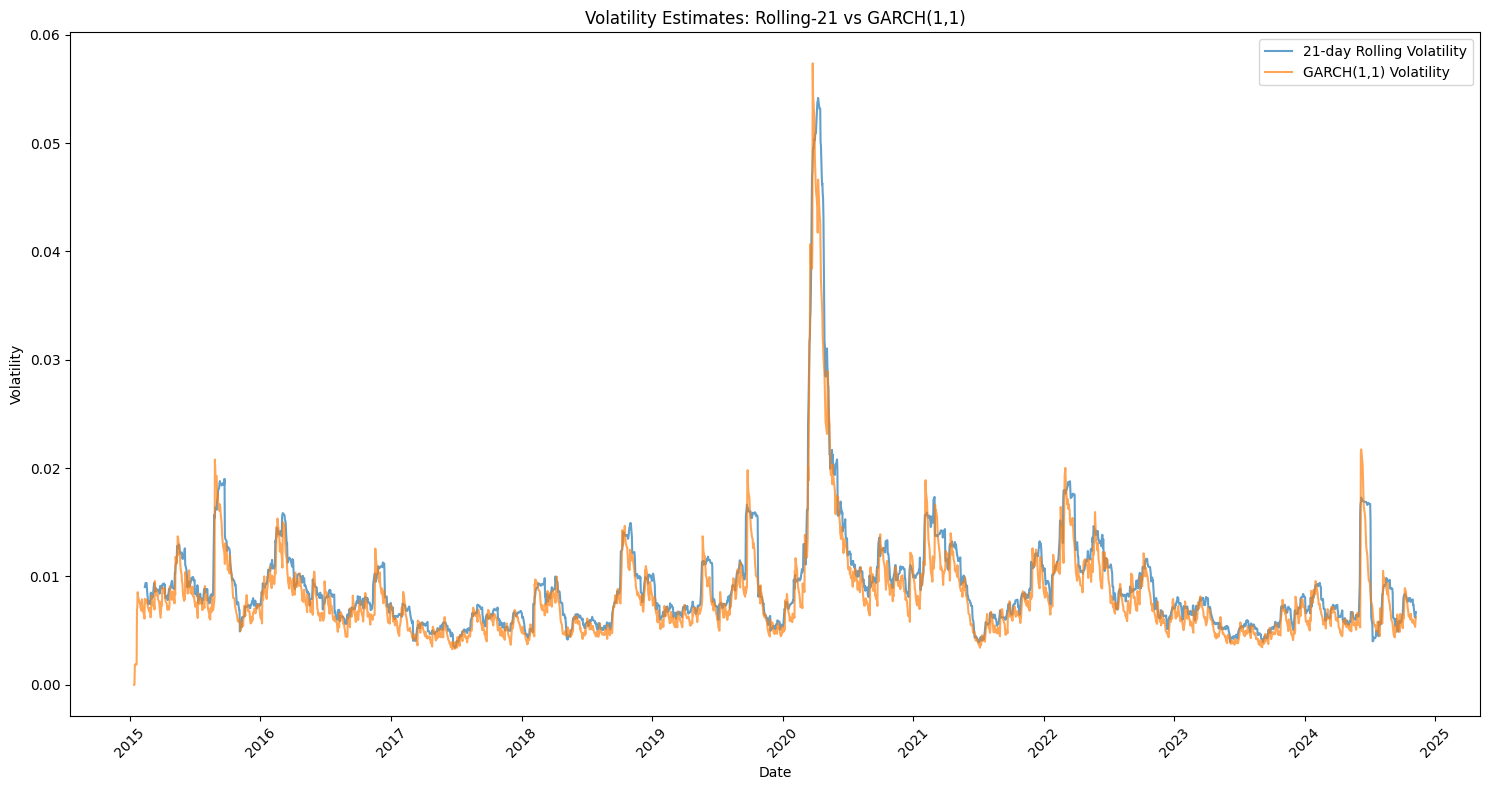

In [8]:
plot_volatility_comparison(daily_data)

## WELL THAT WORKS! AS EXPECTED!

# TIME TO SEE WHAT'S UP WITH DEVESH'S CODE

In [9]:
import pandas as pd
import numpy as np
from arch import arch_model

import matplotlib.pyplot as plt


def fit_garch_model(returns: pd.Series):
    model = arch_model(returns, vol='Garch', p=1, q=1, mean='zero', dist='normal', rescale=True)
    res = model.fit(disp='off')
    print(res.summary())
    # scale = res.scale
    return res

def plot_volatility(df: pd.DataFrame, garch_fitted: pd.Series):
    df['Rolling Volatility'] = np.sqrt((df['Log Returns']**2).rolling(21).mean())
    df['GARCH Volatility'] = (garch_fitted.conditional_volatility)/garch_fitted.scale

    # yeah it was the /garch.scale thing man.
    # idek why they would do that to us
    # also weirdly written lib, they've not tested it fully
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Rolling Volatility'], label='21-Day Rolling Volatility', color='blue')
    plt.plot(df['Date'], df['GARCH Volatility'], label='GARCH(1,1) Volatility', color='orange', linestyle='dashed')
    plt.legend()
    plt.title("Comparison of Historical and GARCH(1,1) Volatility")
    plt.show()




                       Zero Mean - GARCH Model Results                        
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3148.08
Distribution:                  Normal   AIC:                           6302.15
Method:            Maximum Likelihood   BIC:                           6319.53
                                        No. Observations:                 2422
Date:                Sat, Jan 25 2025   Df Residuals:                     2422
Time:                        03:53:28   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0256  9.515e-03      2.693  7.091e-03 [6.

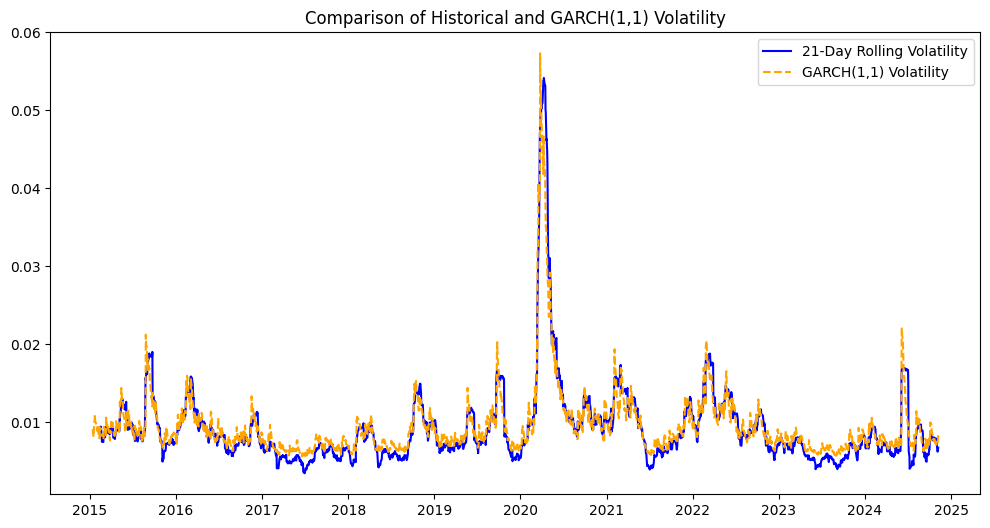

In [10]:
garch_results = fit_garch_model(daily_data['Log Returns'])
plot_volatility(df, garch_results)


In [11]:
# print(garch_results)
print(df['GARCH Volatility'].tail(10))
print(df['Rolling Volatility'].tail(10))

2413    0.007605
2414    0.007292
2415    0.007490
2416    0.007468
2417    0.007249
2418    0.007093
2419    0.006976
2420    0.007471
2421    0.007672
2422    0.008308
Name: GARCH Volatility, dtype: float64
2413    0.007662
2414    0.007858
2415    0.007853
2416    0.007890
2417    0.007374
2418    0.007441
2419    0.006211
2420    0.006210
2421    0.006445
2422    0.006709
Name: Rolling Volatility, dtype: float64


In [12]:
df['GARCH Volatility'].describe()

count    2422.000000
mean        0.009431
std         0.004483
min         0.005568
25%         0.007161
50%         0.008308
75%         0.010271
max         0.057332
Name: GARCH Volatility, dtype: float64

In [13]:
df['Rolling Volatility'].describe()

count    2402.000000
mean        0.009084
std         0.005280
min         0.003425
25%         0.006282
50%         0.007854
75%         0.010287
max         0.054167
Name: Rolling Volatility, dtype: float64